Add your name in this cell:

# Task 3: classification of cell morphology with ResNet
_by David Holmberg (2023)_

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
print(tf.__version__)

2.1.0


## Functions
Don't worry too much about the code in the functions below, but you might want to go through when they are called later on so that you roughly understand what they're doing.

In [2]:
def load_dataset():
    dirname = 'bbbc021v1_images'
    x_orig = np.zeros((660, 256, 256, 3), dtype=np.float32)

    for f in range(x_orig.shape[0]):
        img    = Image.open(dirname + '/bbbc021v1_%s.png' % str(f))
        img    = np.array(img)
        x_orig[f] = img

    labels = pd.read_csv('bbbc021v1_labels.csv',
                          usecols=["compound", "concentration", "moa"],
                          sep=";")
    y_orig = np.array(labels['moa'])

    return x_orig, y_orig

def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])
    y = np.eye(C)[y]
    y = y.astype('float32')

    return y

def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(131)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')    

    ax = fig.add_subplot(133)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def valid_evaluate(model, model_name):
    y_pred = model.predict(X_valid)
    y_pred = y_pred.argmax(axis=-1)
    y_true = Y_valid.argmax(axis=-1)
    
    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    
    print('')
    print('classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3))

## Read in and preprocess the data

In [3]:
X_orig, y_orig = load_dataset()
Y = convert_to_one_hot(y_orig, 6)
X = X_orig/255.

n_train = 500

random.seed(5026)
indices = np.arange(len(Y))
random.shuffle(indices)

X_train, X_valid = X[indices[:n_train]], X[indices[n_train:]]
Y_train, Y_valid = Y[indices[:n_train]], Y[indices[n_train:]]

## ResNet - a deep residual CNN
In this section you will implement a deeper state-of-the-art CNN. Specifically, the CNN that you will implement is not too different from the residual CNN presented by He _et al._ (https://arxiv.org/pdf/1512.03385.pdf). 

A deep residual network contains dozens of residual blocks (see Figure 1) with intermediate normalization. 

<p>
    <img src="figs/residual_block.png" alt="drawing" style="width:400px;"/>
    <center>Figure 1. A residual block - the building block of a residual network.</center>
</p>

The identity mapping is often called a _skip-connection_ or _shortcut_ and has shown to assist in avoiding the degrading effect of training very deep networks --- a degrading effect that is most apparent for "plain" networks. Thus, the residual implementation made it possible to successfully train a very deep CNN that outperformed all the other CNNs that came before.

<p>
    <img src="figs/resnet.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 2. Example of a ResNet architecture.</center>
</p>

### Batch-normalization

Normalization of input can help in improving neural networks. The idea of batch-normalization is to take this normalization to the intermediate layers. Specifically, batch-normalization normalizes the layer's output before it goes through the activation function (hence we no longer do activation within the convolutional layer, but have an additional layer for this). This can make the neural network more stable and faster at training.

Note: although people sometimes use batch normalization and dropout in the same network, these two approaches can sometimes interfere with one another. Hence we will not use dropout in our ResNet models.

## Useful ResNet functions
Fill in the `???` in the code below (based on the guidance given after them).

In [4]:
def conv(inputs, num_filters, strides):
    x = layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu' strides=strides, padding='same',
                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
    return x

def ResNet_block(inputs, num_filters, strides):
    x = conv(inputs, num_filters=num_filters, strides=strides)
    x = layers.BatchNormalization()(x)
    x = conv(x, num_filters=num_filters, strides=1)
    x = layers.BatchNormalization()(x)
    if strides > 1:
        y = conv(inputs, num_filters=num_filters, strides=strides)
        y = layers.BatchNormalization()(y)
    else:
        y = inputs
    z = layers.add([x, y])
    z = layers.Activation('relu')(z)
    return z

## Define ResNet model
Coding ResNet is rather more involved than LeNet. Note, Figure 2 is simply for illustrative purposes, the number of filters there, blocks per stack etc., is different to what we would like you to implement. Your task is to fill in the `???` again (based on the guidance given after them) and then jot down the architecture of the model based on the code in this cell and the one above (keep this succinct, i.e. don't try to write what's going on in every layer, or you'll be here all day (!), just jot down the basics in terms of how it is structured). Once you've done that, run the cell and compare your output with ours. 

Hint: again look to the code given in the lectures for guidance here.

In [5]:
num_classes = 6
inps = layers.Input((256, 256, 3))
x = layers.Conv2D(32, kernel_size=(5, 5), strides=2, padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inps)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

num_stacks = 3
num_blocks_per_stack = [3, 4, 3]
num_filters_in_stack = [64, 128, 256]

for i in range(num_stacks):
    num_filters = num_filters_in_stack[i]
    for j in range(num_blocks_per_stack[i]):
        if(j == 0):
            strides = 2
        else:
            strides = 1
        x = ResNet_block(x, num_filters=num_filters, strides=strides)

x = layers.GlobalAveragePooling2D()(x)
preds = layers.Dense(num_classes, activation='softmax')(x)

ResNet = models.Model(inputs=inps, outputs=preds)
ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Did you code in ResNet correctly?
At the end of the summary you should see the following:

Total params: 4,960,838

Trainable params: 4,953,990

Non-trainable params: 6,848

## Resnet model description
In the 'markdown' cell below replace `???` with your brief summary of your ResNet model architecture.

???

## Compile the ResNet model
Note for the ResNet model we will use a lower learning rate of 0.0001 as opposed to the default value of 0.001 that we used for the LeNet model.

In [6]:
lr = 0.0001
ResNet.compile(optimizer=optimizers.Adam(lr=lr), 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

## Fit and evaluate the ResNet model

Train on 500 samples, validate on 160 samples
Epoch 1/50
500/500 - 7s - loss: 3.0170 - accuracy: 0.4180 - val_loss: 41.3730 - val_accuracy: 0.2375
Epoch 2/50
500/500 - 1s - loss: 1.7037 - accuracy: 0.6400 - val_loss: 3.3113 - val_accuracy: 0.3375
Epoch 3/50
500/500 - 1s - loss: 1.3026 - accuracy: 0.7920 - val_loss: 6.4116 - val_accuracy: 0.2375
Epoch 4/50
500/500 - 1s - loss: 1.0565 - accuracy: 0.8820 - val_loss: 4.0801 - val_accuracy: 0.2562
Epoch 5/50
500/500 - 1s - loss: 0.9093 - accuracy: 0.9380 - val_loss: 4.3836 - val_accuracy: 0.2812
Epoch 6/50
500/500 - 1s - loss: 0.8743 - accuracy: 0.9360 - val_loss: 3.7492 - val_accuracy: 0.3250
Epoch 7/50
500/500 - 1s - loss: 0.8030 - accuracy: 0.9760 - val_loss: 3.7275 - val_accuracy: 0.2062
Epoch 8/50
500/500 - 1s - loss: 0.7444 - accuracy: 0.9880 - val_loss: 3.9957 - val_accuracy: 0.2000
Epoch 9/50
500/500 - 1s - loss: 0.7257 - accuracy: 0.9920 - val_loss: 4.3044 - val_accuracy: 0.1937
Epoch 10/50
500/500 - 1s - loss: 0.7190 - accuracy: 0

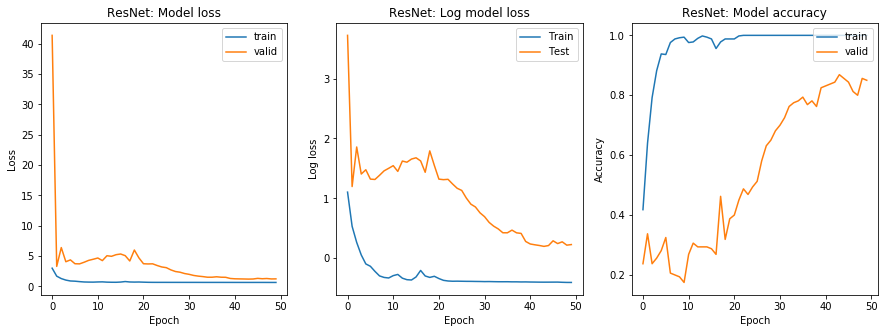

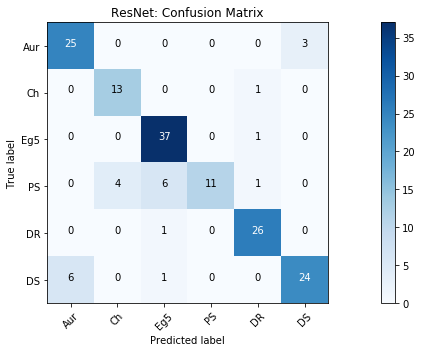


classification report for validation data:
              precision    recall  f1-score   support

           0      0.806     0.893     0.847        28
           1      0.765     0.929     0.839        14
           2      0.822     0.974     0.892        38
           3      1.000     0.500     0.667        22
           4      0.897     0.963     0.929        27
           5      0.889     0.774     0.828        31

    accuracy                          0.850       160
   macro avg      0.863     0.839     0.833       160
weighted avg      0.864     0.850     0.842       160



In [7]:
batch_size = 32
n_epochs = 50

history = ResNet.fit(X_train, Y_train,
                     batch_size=batch_size,
                     epochs=n_epochs,
                     validation_data=(X_valid, Y_valid),
                     verbose=2)

plot_history(history, 'ResNet')
valid_evaluate(ResNet, 'ResNet')

## Multiple runs of the same model
Again, as we did for the LeNet model, re-run your ResNet model 5 times to compute the mean 'weighted avg f1-score'. Show this in the code cell below. For my five runs I got:

(0.769 + 0.815 + 0.720 + 0.777 + 0.842) / 5 = 0.785

## Notes
Your probably noticed that the training was quite eratic for your ResNet model above (i.e. the training curve was quite jaggedy). We could combat this with changes to the model architecture, the batch size and learning rate. We could also perhaps improve things with data augmentation. We will not explore these modifications here though.

This was a big model that we trained, with almost 5 million parameters. With only 500 images for training this was rather ambitious! A better way to deal with a small dataset size, when we still want to fit a fairly complex and descriptive model (that will hopefully make good predictions), is to use transfer learning. This will be the focus of part 3 of the assignemnt.